# NON VA SHAP E INTERPRET (EBM) SU PYTHON 3.12

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [2]:
df_incidents_prepared = pd.read_csv('../dataset_preparation/incidents_prepared.csv', index_col=0)
df_orig = pd.read_csv('../dataset_preparation/original_features.csv', index_col=0)

In [3]:
df_incidents_prepared=df_incidents_prepared.join(df_orig)
df_incidents_prepared.info()

<class 'pandas.core.frame.DataFrame'>
Index: 161550 entries, 0 to 164506
Data columns (total 41 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   date                       161550 non-null  object 
 1   state                      161550 non-null  object 
 2   city_or_county             161550 non-null  object 
 3   address                    149848 non-null  object 
 4   latitude                   161550 non-null  float64
 5   longitude                  161550 non-null  float64
 6   congressional_district     161550 non-null  float64
 7   avg_age_participants       161550 non-null  float64
 8   n_killed                   161550 non-null  int64  
 9   incident_characteristics1  161550 non-null  object 
 10  year                       161550 non-null  float64
 11  age_group                  161550 non-null  object 
 12  povertyPercentage          161550 non-null  float64
 13  population                 161550 

In [4]:
df_incidents_prepared['isKilled'] = df_incidents_prepared['n_killed'] > 0

In [5]:
cols2drop=[
            #categorical features difficult to encode
           'address', 'city_or_county','congressional_district','date','state', 'year_month',
           'avg_age_participants', # we already have age_group
           'n_killed',  #label
           'incident_characteristics1', # too similar to the label isKilled
           'severity', 'severity_cat', # created from n_killed

           # we decided to use original features n_females, n_injured etc. all those features are highly correlated. We decided to keep the original features because they are more interpretable
           'killed_by_district','injured_by_district', 'dfm_district_killed','dfm_district_injured', 'dfm_district_participants', 'dfm_district_child', 'dfm_district_teen', 'dfm_district_females', 'arrested_ratio', 'unharmed_ratio', 'severity_minor',

           # correlated with n_participants
            'n_participants_adult'
            ]
df_incidents_prepared=df_incidents_prepared.drop(cols2drop, axis=1)

In [6]:
df_incidents_prepared.info()

<class 'pandas.core.frame.DataFrame'>
Index: 161550 entries, 0 to 164506
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   latitude                161550 non-null  float64
 1   longitude               161550 non-null  float64
 2   year                    161550 non-null  float64
 3   age_group               161550 non-null  object 
 4   povertyPercentage       161550 non-null  float64
 5   population              161550 non-null  int64  
 6   party                   161550 non-null  object 
 7   candidatevotes          161550 non-null  float64
 8   right_or_left           161550 non-null  float64
 9   voters_over_population  161550 non-null  float64
 10  n_arrested              161550 non-null  float64
 11  n_participants          161550 non-null  float64
 12  n_participants_teen     161550 non-null  float64
 13  n_participants_child    161550 non-null  float64
 14  n_females               1

In [7]:
X=df_incidents_prepared.drop('isKilled', axis=1)
X.drop(['n_unharmed', 'n_arrested'], axis=1, inplace=True)
y=df_incidents_prepared['isKilled']
X.head()

latitude  longitude    year age_group  povertyPercentage  population  \
0   39.8322   -86.2492  2015.0   [18-24]               12.3     6608422   
1   39.7745   -86.1166  2015.0   [25-34]               12.3     6608422   
2   39.7759   -86.2940  2015.0   [35-44]               12.3     6608422   
3   39.8040   -86.0095  2015.0   [18-24]               12.3     6608422   
4   39.7882   -86.2091  2015.0   [45-54]               12.3     6608422   

      party  candidatevotes  right_or_left  voters_over_population  \
0  DEMOCRAT         61443.0       0.452677                0.203046   
1  DEMOCRAT         61443.0       0.452677                0.203046   
2  DEMOCRAT         61443.0       0.452677                0.203046   
3  DEMOCRAT         61443.0       0.452677                0.203046   
4  DEMOCRAT         61443.0       0.452677                0.203046   

   n_participants  n_participants_teen  n_participants_child  n_females  \
0             1.0                  0.0                   0.0        0.0   
1             2.0                  0.0                   0.0        0.0   
2             2.0                  0.0                   0.0        0.0   
3             1.0                  0.0                   0.0        0.0   
4             1.0                  0.0                   0.0        0.0   

   n_males  n_injured  
0      1.0          1  
1      2.0          0  
2      2.0          0  
3      1.0          0  
4      1.0          1

In [8]:
X=pd.get_dummies(X)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 161550 entries, 0 to 164506
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   latitude                161550 non-null  float64
 1   longitude               161550 non-null  float64
 2   year                    161550 non-null  float64
 3   povertyPercentage       161550 non-null  float64
 4   population              161550 non-null  int64  
 5   candidatevotes          161550 non-null  float64
 6   right_or_left           161550 non-null  float64
 7   voters_over_population  161550 non-null  float64
 8   n_participants          161550 non-null  float64
 9   n_participants_teen     161550 non-null  float64
 10  n_participants_child    161550 non-null  float64
 11  n_females               161550 non-null  float64
 12  n_males                 161550 non-null  float64
 13  n_injured               161550 non-null  int64  
 14  age_group_[0-11]        1

In [9]:
X3_train, X3_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Decision Tree

In [11]:
best_params_dt={
"criterion": 'gini',
"max_depth": 16,
"min_samples_split": 16
}
best_tree=DecisionTreeClassifier(**best_params_dt)
best_tree.fit(X3_train,y_train)

DecisionTreeClassifier(max_depth=16, min_samples_split=16)

In [12]:
y_pred = best_tree.predict(X3_test)

## Lime for DT

In [29]:
import lime
import lime.lime_tabular
features = list(X.columns)
explainer = lime.lime_tabular.LimeTabularExplainer(X3_train.values, feature_names = features)

In [36]:
exp = explainer.explain_instance(X3_test.values[0], best_tree.predict_proba)
exp.show_in_notebook(show_table=True, show_all=True)

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


In [37]:
exp = explainer.explain_instance(X3_test.values[1], best_tree.predict_proba)
exp.show_in_notebook(show_table=True, show_all=True)

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


## Shap for DT

In [18]:
import shap
expl_tree=shap.Explainer(best_tree)
shap_values_tree = expl_tree.shap_values(X3_test)

In [43]:
type(shap_values_t)

list

In [41]:
shap.plots.bar(shap_values_t)

IndexError: list index out of range

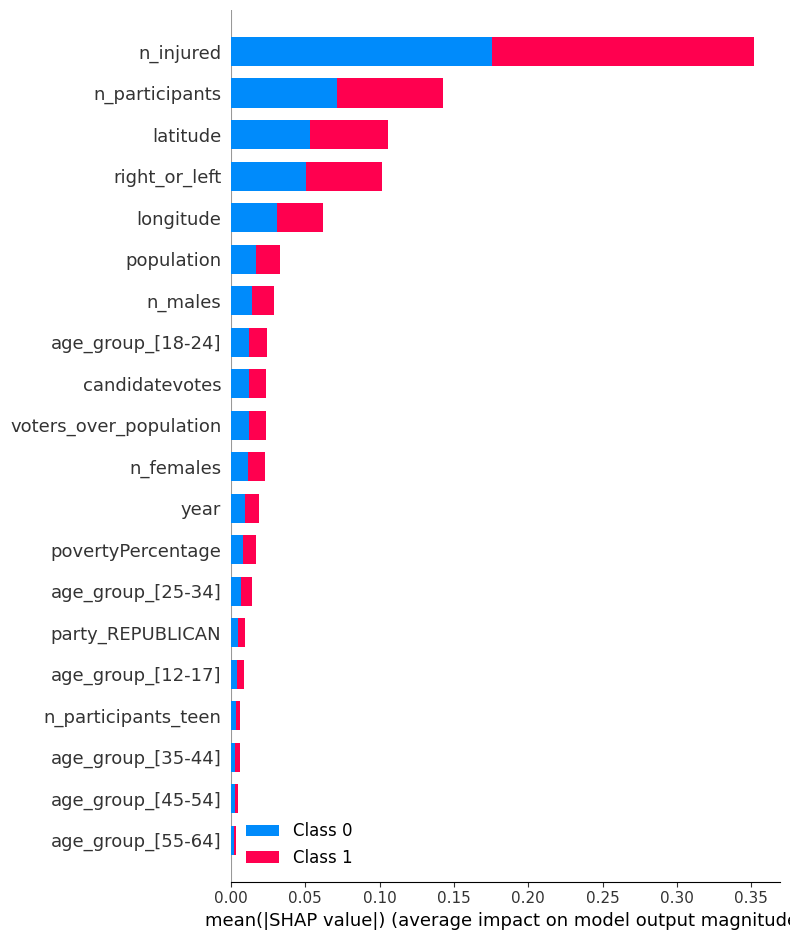

In [19]:
shap.summary_plot(shap_values_tree, X3_test)

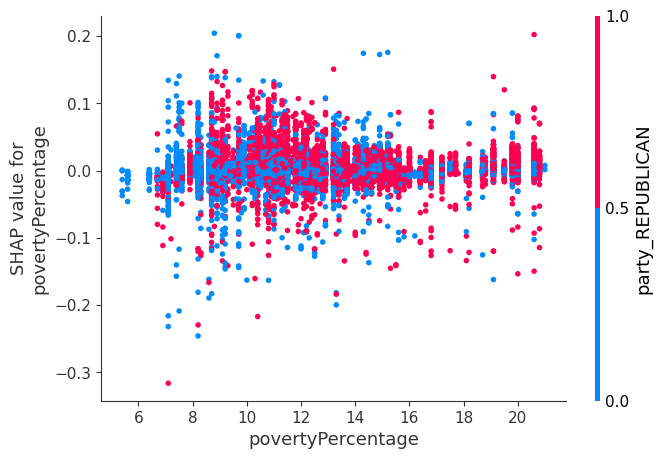

In [50]:
attr="povertyPercentage"
shap.dependence_plot(ind=attr, shap_values=shap_values_tree[0], features=X3_test)

In [61]:
type(shap_values_t)

shap._explanation.Explanation

In [64]:
shap.plots.scatter(shap_values_t[:, 24,0], color=shap_values_t)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 3 dimension(s)

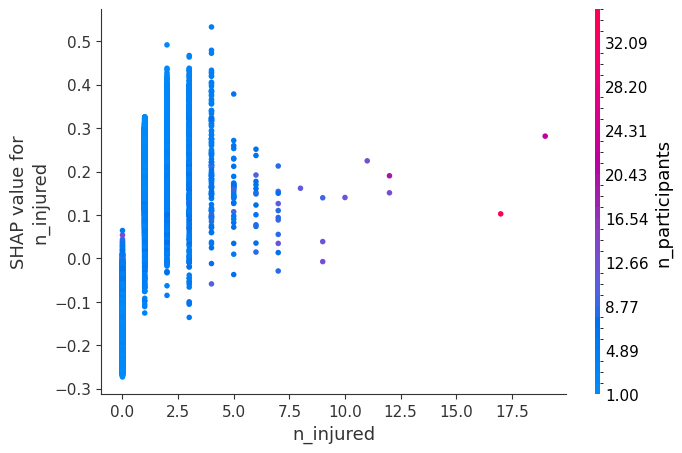

In [52]:
attr="n_injured"
shap.dependence_plot(ind=attr, shap_values=shap_values_tree[0], features=X3_test[1:1000])

In [21]:
shap_values_t = expl_tree(X3_test)


In [22]:
shap_values_t[0]

.values =
array([[ 3.69100972e-02, -3.69100972e-02],
       [ 1.14942251e-02, -1.14942251e-02],
       [ 8.51198856e-04, -8.51198856e-04],
       [-9.64951440e-03,  9.64951440e-03],
       [ 1.19444153e-02, -1.19444153e-02],
       [ 5.47143555e-03, -5.47143555e-03],
       [-3.81196218e-03,  3.81196218e-03],
       [ 3.44252458e-03, -3.44252458e-03],
       [-3.20341442e-02,  3.20341442e-02],
       [ 2.89882681e-04, -2.89882681e-04],
       [ 3.00635610e-04, -3.00635610e-04],
       [-4.51430962e-02,  4.51430962e-02],
       [ 1.39465915e-02, -1.39465915e-02],
       [ 9.59092948e-02, -9.59092948e-02],
       [ 1.12522822e-05, -1.12522822e-05],
       [ 2.54850120e-04, -2.54850120e-04],
       [-2.35844913e-02,  2.35844913e-02],
       [-5.69112334e-03,  5.69112334e-03],
       [ 5.78034115e-04, -5.78034115e-04],
       [ 2.02776723e-03, -2.02776723e-03],
       [ 1.03900205e-03, -1.03900205e-03],
       [ 3.61804238e-04, -3.61804238e-04],
       [ 4.19068547e-04, -4.19068547e-04],
 

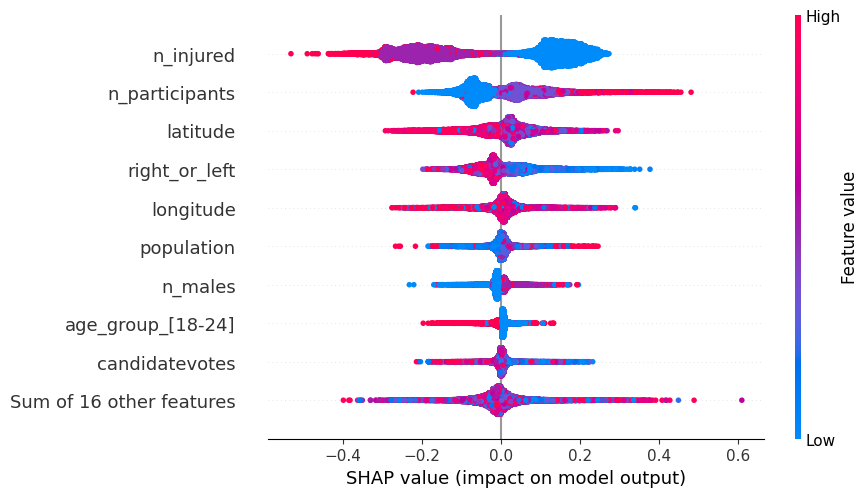

In [23]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values_t[:,:,1])

On the above plot, positive SHAP values indicate an higher probability to be predicted as True, while negative to be predicted as False. 
The color approaches to fucsia as the feature value is higher, while it moves to cyan when it's lower. 
The agglomerations indicate that more instances have that SHAP value, so when 

In [160]:
shap.initjs()


In [161]:
shap.plots.force(shap_values_t[1,:,1])

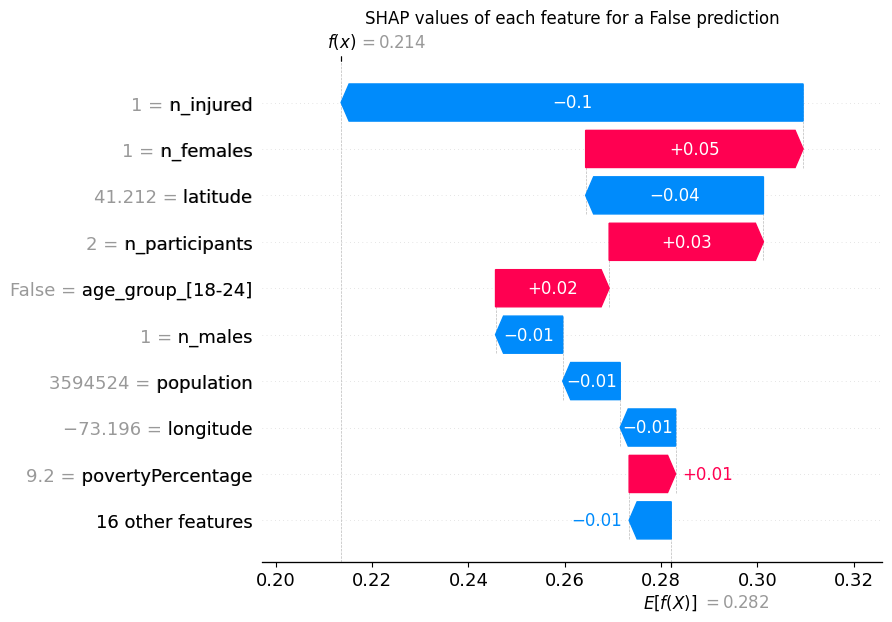

In [27]:
plt.title('SHAP values of each feature for a False prediction')
shap.plots.waterfall(shap_values_t[0,:,1])

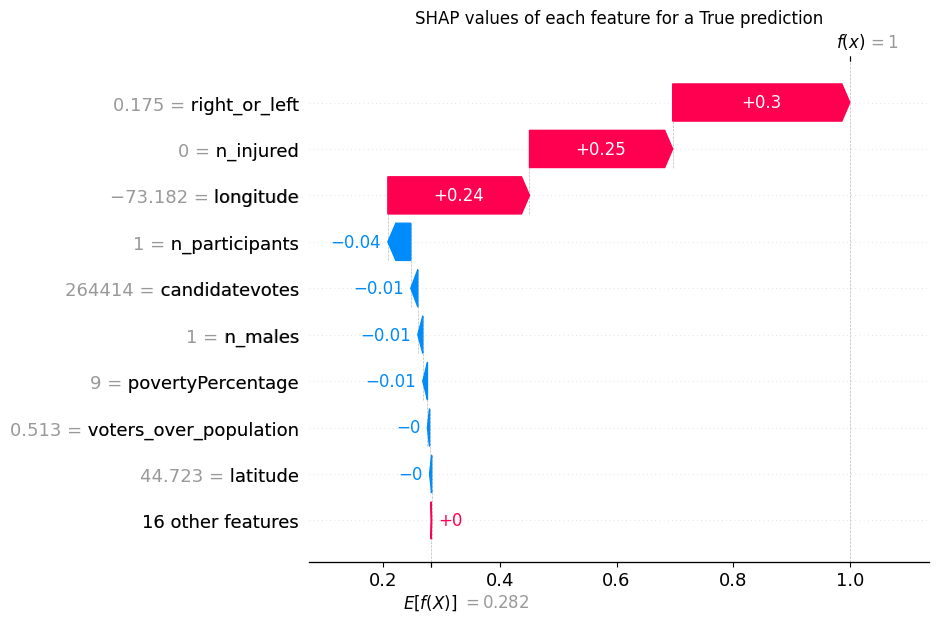

In [26]:
plt.title('SHAP values of each feature for a True prediction')
shap.plots.waterfall(shap_values_t[1,:,1])


In [131]:
y_test[y_test==True]

In [ ]:
y_test.get_loc(55270)

In [144]:
np.where(y_pred==True)

(array([    1,     2,     9, ..., 32294, 32298, 32300], dtype=int64),)

In [113]:
type(shap_values_t[0,:,0])
#print(shap_values_t[0,:])

shap._explanation.Explanation

# Random Forest 

In [14]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(criterion='entropy', max_depth=16, min_samples_split=2, n_estimators=50)
rf.fit(X3_train, y_train)
y_pred = rf.predict(X3_test)

## Lime for Random Forests

In [ ]:
features = list(X.columns)
explainer = lime.lime_tabular.LimeTabularExplainer(X3_train.values, feature_names = features)

In [56]:
exp = explainer.explain_instance(X3_test.values[0], rf.predict_proba, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=True)

c:\Users\Giamm\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


## Shap for Random Forest

In [15]:
import shap
expl_rf=shap.Explainer(rf)
shap_values_rf = expl_rf.shap_values(X3_test[0:1000])

In [ ]:
shap.summary_plot(shap_values_rf, X3_test)

In [ ]:
attr="n_participants"
shap.dependence_plot(ind=attr, shap_values=shap_values_rf[0], features=X3_test)

In [ ]:
shap_values_randf= expl_rf(X3_test)

In [ ]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values_randf[:,:,1])

# Logistic Regression

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
scaler = StandardScaler()
X3_train_scaled = scaler.fit_transform(X3_train)
X3_test_scaled = scaler.fit_transform(X3_test)
logreg = LogisticRegression()
logreg.fit(X3_train_scaled, y_train)
results_logreg = evaluate_model(logreg, X3_train_scaled, y_train, X3_test_scaled, y_test)

Accuracy on training set:  0.7344011142061281
confusion_matrix on training set: 
 [[85769  7013]
 [27313  9145]]
Accuracy on validation set:  0.7361188486536676
Confusion matrix: 
 [[21510  1839]
 [ 6687  2274]]
Classification report: 
               precision    recall  f1-score   support

       False       0.76      0.92      0.83     23349
        True       0.55      0.25      0.35      8961

    accuracy                           0.74     32310
   macro avg       0.66      0.59      0.59     32310
weighted avg       0.70      0.74      0.70     32310



In [26]:
for i in zip (X.columns, logreg.coef_[0]):
    print(i)

('latitude', -0.22917818567989431)
('longitude', -0.13643665298914695)
('year', 0.04278087568532504)
('povertyPercentage', 0.006147886785480077)
('population', -0.046019507693895206)
('candidatevotes', 0.07784826495094252)
('right_or_left', -0.2511111730208183)
('voters_over_population', -0.21389499052959432)
('n_participants', 0.15523234538714076)
('n_participants_teen', -0.003722495966066641)
('n_participants_child', 0.03999945607378677)
('n_females', 0.19782540060864195)
('n_males', 0.29905678314869155)
('n_injured', -1.0805625568383905)
('age_group_[0-11]', -0.057796256382977765)
('age_group_[12-17]', -0.13745322243347372)
('age_group_[18-24]', -0.08501543791857322)
('age_group_[25-34]', 0.027522491770377747)
('age_group_[35-44]', 0.06813635207166191)
('age_group_[45-54]', 0.08894888809651137)
('age_group_[55-64]', 0.07200461899615367)
('age_group_[65-74]', 0.04048558328731962)
('age_group_[75-100]', 0.03361233696224186)
('party_DEMOCRAT', 0.004908064854367499)
('party_REPUBLICAN',

## Shap for LogReg

In [73]:
from shap import maskers
shap_values_logreg = shap.LinearExplainer(logreg, X3_train_scaled, maskers.Independent).shap_values(X3_test)

In [76]:
shap_values_logreg.shape

(32310, 25)

In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
X_test_np=np.array(X3_test)
X_test_array = X_test_np.toarray() # we need to pass a dense version for the plotting functions

AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

In [66]:
shap.summary_plot(shap_values_logreg, X_test_array, feature_names=vectorizer.get_feature_names())

NameError: name 'X_test_array' is not defined

TypeError: loop of ufunc does not support argument 0 of type float which has no callable rint method

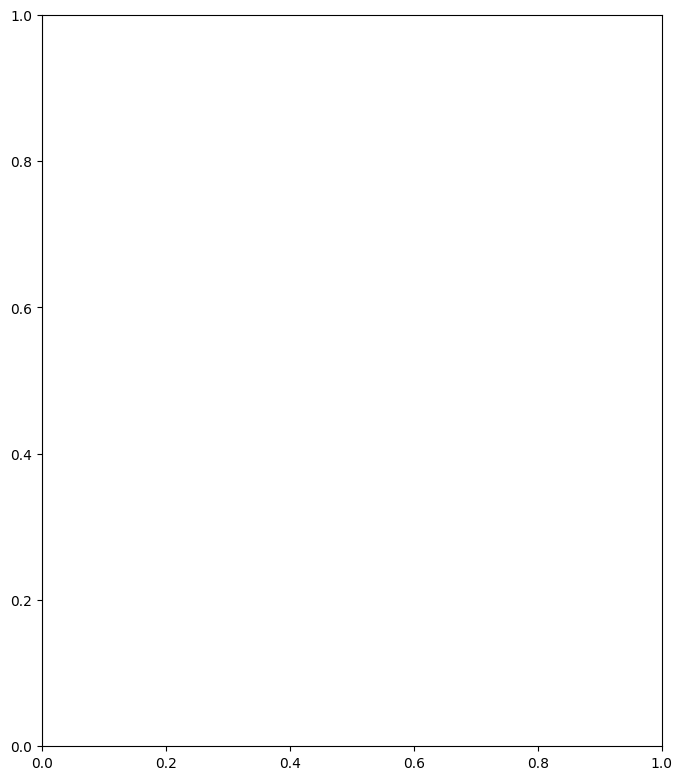

In [78]:
shap.summary_plot(shap_values_logreg, X3_test)

# EBM

In [66]:
from interpret.glassbox import ExplainableBoostingClassifier
import pickle

In [76]:
X3_train_prova= X3_train.head(1000)
y_train_prova=y_train.head(1000)
X3_train_prova.shape

(1000, 25)

In [77]:
ebm = ExplainableBoostingClassifier()
ebm.fit(X3_train_prova, y_train_prova)

ExplainableBoostingClassifier()

In [78]:
from interpret import show

ebm_global = ebm.explain_global(name='EBM Adult Global')
show(ebm_global)

<!-- http://127.0.0.1:7001/2918029382352/ -->